# Linear Regression  on a Combined Cycle Power Plant (CCPP) data
## Dataset description

The dataset contains 5281 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (AT), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (PE)  of the plant.

A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum has effect on the Steam Turbine, the other three of the ambient variables effect the GT performance.

In [41]:
# to get in-line plots
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd

## Import Data
Load the data from a .csv file and print data column names.

**TO DO:** insert your ID number (matricola)


In [42]:
# Load the data

IDnumber =  2080603
np.random.seed(IDnumber)

filename = "ccpp_Data_clean2019.csv"

df = pd.read_csv(filename,sep=";")

col_names = df.columns
print(col_names)

data = df.values

Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')


# A quick overview of data

To inspect the data you can use the method describe()

In [43]:
data_description = stats.describe(data)
print(data_description)
data.shape

#for more interesting visualization: use pandas!

DescribeResult(nobs=5281, minmax=(array([  1.81,  25.36, 992.89,  25.56, 420.26]), array([  37.11,   81.56, 1033.29,  100.16,  495.23])), mean=array([  19.67317553,   54.31940163, 1013.22432115,   73.38815187,
        454.31701004]), variance=array([ 56.0327041 , 161.7733201 ,  35.2083789 , 217.43618617,
       291.84459771]), skewness=array([-0.13713412,  0.19522075,  0.24934713, -0.43467097,  0.29846615]), kurtosis=array([-1.04662553, -1.45165813,  0.01128758, -0.43044229, -1.05785395]))


(5281, 5)

# Split data in training, validation and test sets



Given $m$ total data, keep $m_t$ data as training data, $m_{val}:=m_{tv}-m_t$ as validation data and $m_{test}:=m - m_{val} - m_t = m-m_{tv}$ for test data. For instance one can take $m_t=m/3$ of the data as training, $m_{val}=m/3$  validation and $m_{test}=m/3$ as testing. Let us define as define

$\bullet$ $S_{t}$ the training data set

$\bullet$ $S_{val}$ the validation data set

$\bullet$ $S_{test}$ the testing data set


The reason for this splitting is as follows:

TRAINING DATA: The training data are used to compute the training loss
$$
L_S(h) = \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
which is used to estimate $h$ in a given model class ${\cal H}$.
i.e. 
$$
\hat h = {\rm arg\; min}_{h \in {\cal H}} \, L_S(h)
$$

VALIDATION DATA: Validation data are used when different model classes are present (e.g. of different complexity such as linear regression which used a different number $d_j$ of features $x_1$,...$x_{d_j}$ in the model). In general, with more features one can better fit the training set, so one has to choose which one is the "best" complexity. Let ${\cal H}_{d_j}$ be the space of models as a function of the complexity $d_j$ and let 
$$
\hat h_{d_j} = {\rm arg\; min}_{h \in {\cal H}_{d_j}} \, L_S(h)
$$

One can estimate the generalization error for model $\hat h_{d_j}$ as follows:
$$
L_{{\cal D}}(\hat h_{d_j}) \simeq \frac{1}{m_{val}} \sum_{ z_i \in S_{val}} \ell(\hat h_{d_j},z_i)
$$
and then choose the complexity which achieves the best estimate of the generalization error
$$
\hat d: = {\rm arg\; min}_{d_j} \,\frac{1}{m_{val}} \sum_{ z_i \in S_{val}} \ell(\hat h_{d_j},z_i)
$$

TESTING DATA: Last, the test data set can be used to estimate the performance of the final estimated model
$\hat h_{\hat d_j}$ using:
$$
L_{{\cal D}}(\hat h_{\hat d_j}) \simeq \frac{1}{m_{test}} \sum_{ z_i \in S_{test}} \ell(\hat h_{\hat d_j},z_i)
$$


**TO DO**: split the data in training, validation and test sets (suggestion: use $m_t=m_{val} = \lfloor\frac{m}{3}\rfloor$, $m_{test} = m-m_t-m_{val}$)

In [44]:
#get number of total samples
num_total_samples = data.shape[0]

print("Total number of samples: "+str(num_total_samples))

#size of each chunk of data for training, validation, testing
size_chunk = int(num_total_samples/3.)

print("Size of each chunk of data: "+str(size_chunk))

#shuffle the data
np.random.shuffle(data)

X = data[:,:4]
Y = data[:,4]


X_training = X[:size_chunk]
Y_training = Y[:size_chunk]
print("Training data input size: "+str(X_training.shape))
print("Training data output size: "+str(Y_training.shape))

#validation data, to be used to choose among different models
X_validation = X[size_chunk:size_chunk*2]
Y_validation = Y[size_chunk:size_chunk*2]
print("Validation data input size: "+str(X_validation.shape))
print("Validation data ouput size: "+str(Y_validation.shape))

#test data, to be used to estimate the true loss of the final model(s)
X_test = X[size_chunk*2:size_chunk*3]
Y_test = Y[size_chunk*2:size_chunk*3]
print("Test data input size: "+str(X_test.shape))
print("Test data output size: "+str(Y_test.shape))

Total number of samples: 5281
Size of each chunk of data: 1760
Training data input size: (1760, 4)
Training data output size: (1760,)
Validation data input size: (1760, 4)
Validation data ouput size: (1760,)
Test data input size: (1760, 4)
Test data output size: (1760,)


# Data Normalization

It is common practice in Statistics and Machine Learning to scale the data (= each variable) so that it is centered (zero mean) and has standard deviation equal to $1$. This helps in terms of numerical stability (conditioning) of the (inverse) problems of estimating the ERM model (the coefficients of the linear regression in this case), as well as to give the same scale to all the coefficients. 

In [45]:
# standardize the input matrix
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_training)
X_training = scaler.transform(X_training)
print("Mean of the training input data:"+str(X_training.mean(axis=0)))
print("Std of the training input data:"+str(X_training.std(axis=0)))
X_validation = scaler.transform(X_validation) # use the same transformation on validation data
print("Mean of the validation input data:"+str(X_validation.mean(axis=0)))
print("Std of the validation input data:"+str(X_validation.std(axis=0)))
X_test = scaler.transform(X_test) # use the same transformation on test data
print("Mean of the test input data:"+str(X_test.mean(axis=0)))
print("Std of the test input data:"+str(X_test.std(axis=0)))



Mean of the training input data:[ 2.87144046e-16  2.90676574e-16 -2.19016724e-14  1.85710033e-16]
Std of the training input data:[1. 1. 1. 1.]
Mean of the validation input data:[ 0.00711532 -0.00602408 -0.00756958 -0.01845711]
Std of the validation input data:[1.00200028 0.99963464 0.98557717 1.00901325]
Mean of the test input data:[-0.0358503  -0.03709699 -0.01737215  0.03982509]
Std of the test input data:[1.01086507 1.01696754 1.03434018 0.99602553]


# Model Training 

The model is trained (= estimated) minimizing the empirical error
$$
L_S(h) := \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
where $z_i = (x_i,y_i)$.
When the loss function is the quadratic loss
$$
\ell(h,z) := (y - h(x))^2
$$
we define  the Residual Sum of Squares (RSS) as
$$
RSS(h):= \sum_{z_i \in S_{t}} \ell(h,z_i) = \sum_{z_i \in S_{t}} (y_i - h(x_i))^2
$$ so that the training error becomes
$$
L_S(h) = \frac{RSS(h)}{m_t}
$$

We recal that, for linear models we have $h(x) = <w,x>$ and the Empirical error $L_S(h)$ can be written
in terms of the vector of parameters $w$ in the form
$$
L_S(w) = \frac{1}{m_t}(y - Xw)^T(y-Xw) =  \frac{1}{m_t} \|y - X w\|^2
$$
where $y$ is the vector whose $i-th$ element is the output datum $y_i$ and $X$ is the matrix whose $i-$th row is the input vector $x_i^\top$.

The least squares solution is given by the expression
$$
\hat w = {\rm arg\;min}_w L_S(w) = (X^\top X)^{-1} X^\top Y
$$
When the matrix $X$ is not invertible, the solution can be computed using the Moore-Penrose pseudonverse $(X^\top X)^{\dagger}$ of $(X^\top X)$
$$
\hat w = (X^\top X)^{\dagger} X^\top Y
$$


 In practice some of the singular values may be very small (e.g. $<1e-12$). Therefore it makes sense to 
 first approximate the matrix $A$ truncating the SVD and then using the pseudoinverse formula.
 
 More specifically, let us postulate that, given a threshold $T_h$ (e.g $=1e-12$), we have $\sigma_i<T_h$, for $i=\hat r + 1,..,r$. Then we can approximate (by SVD truncation) $A$ using:
 
 $$A = USV^\top =U \,{\rm diag}\{s_1,s_2,..,s_r\}\, V^\top \simeq \hat A_r = U\,{\rm diag}\{s_1,s_2,..,s_{\hat r}, 0,..,0\}\,V^\top
 $$
 So that 
 $$
 A^\dagger \simeq \hat A_r^\dagger:= V \,{\rm diag}\{1/s_1,1/s_2,..,1/s_{\hat r}, 0,..,0\}\, U^\top
 $$
 
 The linear regression coefficients can be computed directly using the numyp.linalg.lstsq function
  
 **TO DO**: compute the linear regression coefficients using the numpy.linalg.lstsq function

In [46]:
X_training.shape[0]

1760

In [47]:
#compute linear regression coefficients for training data

#add a 1 at the beginning of each sample for training, validation, and testing
m_training = X_training.shape[0]
X_training = np.hstack((np.ones((m_training,1)),X_training))

m_validation = X_validation.shape[0]
X_validation = np.hstack((np.ones((m_validation,1)),X_validation))

m_test = X_test.shape[0]
X_test = np.hstack((np.ones((m_test,1)),X_test))

# Compute the coefficients for linear regression (LR) using linalg.lstsq
w_np, RSS_tr_np, rank_X_tr, sv_X_tr= np.linalg.lstsq(X_training, Y_training, rcond=None)


print("LR coefficients with numpy lstsq: "+ str(w_np))

# compute Residual sums of squares by hand
print("RSS with numpy lstsq: "+str(RSS_tr_np))
print("Empirical risk with numpy lstsq:"+str(RSS_tr_np/m_training))



LR coefficients with numpy lstsq: [ 4.54090466e+02 -1.49178688e+01 -2.78189126e+00  4.42497703e-01
 -2.45893068e+00]
RSS with numpy lstsq: [35537.04539797]
Empirical risk with numpy lstsq:[20.19150307]


## Data prediction 

Compute the output predictions on both training and validation set and compute the Residual Sum of Sqaures (RSS) defined above, and the Emprical Loss. Compute also the quantity $R^2$ where
$$
R^2 = 1 - \frac{\sum_{z_i \in S_t} (\hat y_i - y_i)^2}{\sum_{z_i \in S_t} (y_i - \bar y)^2} \quad \quad \bar y = \frac{1}{m_t} \sum_{z_i \in S_t} y_i
$$
is the so-called "Coefficient of determination" (COD)

**TO DO**: Compute these quantities on  training, validation and test sets.


In [48]:

#compute predictions on training set, validation set, and test set
prediction_training = np.dot(X_training , w_np) # COMPLETE
prediction_validation = np.dot(X_validation , w_np) # COMPLETE
prediction_test = np.dot(X_test , w_np)# COMPLETE

#what about the RSS and loss for points in the validation data?
RSS_training = sum((prediction_training - Y_training ) **2)
RSS_validation = sum((prediction_validation - Y_validation ) **2)   # COMPLETE
RSS_test = sum((prediction_test - Y_test ) **2) # COMPLETE

print("RSS on validation data: "+str(RSS_validation))
print("Loss estimated from validation data:"+str(RSS_validation/m_validation))

#avaz konm
y_training_mean = np.mean(Y_training)
y_validation_mean = np.mean(Y_validation)
y_test_mean = np.mean(Y_test)


y_bar_loss_training = sum((Y_training - y_training_mean) **2)
y_bar_loss_validation = sum((Y_validation - y_validation_mean) **2)
y_bar_loss_test = sum((Y_test - y_test_mean) **2)

#another measure of how good our linear fit is given by the following (that is 1 - R^2)
#compute R^2 for training, validation, and test set
R_measure_training = 1 - (RSS_training / y_bar_loss_training)  #COMPLETE
R_measure_validation = 1 - (RSS_validation / y_bar_loss_validation)  #COMPLETE 
R_measure_test = 1 - (RSS_test / y_bar_loss_test) #COMPLETE

print("Measure on Training Data (1-R^2):"+str(R_measure_training))
print("Measure on Validation Data(1-R^2):"+str(R_measure_validation))
print("Measure on Test Data(1-R^2):"+str(R_measure_test))



RSS on validation data: 37321.23351836313
Loss estimated from validation data:21.205246317251778
Measure on Training Data (1-R^2):0.9307515379878717
Measure on Validation Data(1-R^2):0.9265915996206371
Measure on Test Data(1-R^2):0.9270259045234766


## ... and plot:


### (1) output predictions on training  data

Note that in the following plot and in the analogous plots below the data is permuted so that the predictions are increasing with the index of the instance in the plot. **This is just to make the plot look nice!**

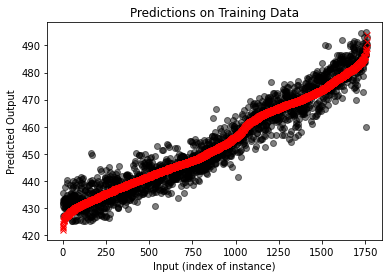

In [49]:
# Plot predictions on Training data 
plt.figure()

#the following is just for nice plotting, not required: it sorts the predictions by value so that they fall on
# a line and it's easier to spot the differences
sorting_permutation = sorted(range(len(prediction_training[0:m_training])), key=lambda k: prediction_training[0:m_training][k])
plt.plot(Y_training[sorting_permutation], 'ko', alpha=0.5)
plt.plot(prediction_training[sorting_permutation], 'rx')

plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Training Data')
plt.show()

### (2) output predictions on validation  data

Plot predictions on validation data.

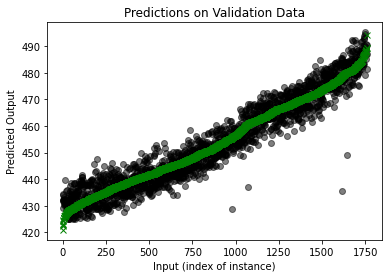

In [50]:
# Plot predictions on validation data 
plt.figure()

#the following is just for nice plotting, not required: it sorts the predictions by value so that they fall on
# a line and it's easier to spot the differences
sorting_permutation = sorted(range(len(prediction_validation[0:m_validation])), key=lambda k: prediction_validation[0:m_validation][k])
plt.plot(Y_validation[sorting_permutation], 'ko', alpha=0.5)
plt.plot(prediction_validation[sorting_permutation], 'gx')


plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Validation Data')
plt.show()

# Removing some features

Perform same as above removing 1 feature that you think may not be as important as the other ones for prediction; recall that, since the data has been normalized, may be done by looking at the weights of each feature in the learned model.

**TO DO**: repeat the learning procedure after having removed 1 feature that you considered less important and explain the choice of which regressors to be removed.

according to "w_np" we delete column which is less than the others, it means it has less effect in our model

In [51]:
# reduced design matrix

number_features = len(w_np)
features_indexes_array = np.array(range(0, number_features))
new_feature_array = np.delete(features_indexes_array , np.argmin(abs(w_np)))
selected_features = new_feature_array #COMPLETE
    
X_training_reduced = X_training[:,selected_features]
X_validation_reduced = X_validation[:,selected_features]
X_test_reduced = X_test[:,selected_features]                                  
                                  

m_training_reduced = X_training_reduced.shape[0]
X_training_reduced = np.hstack((np.ones((m_training_reduced,1)),X_training_reduced))

m_validation_reduced = X_validation_reduced.shape[0]
X_validation_reduced = np.hstack((np.ones((m_validation_reduced,1)),X_validation_reduced))

m_test_reduced = X_test_reduced.shape[0]
X_test_reduced = np.hstack((np.ones((m_test_reduced,1)),X_test_reduced))

w_np_reduced, RSS_tr_np_reduced, rank_Xtr_reduced, sv_Xtr_reduced = np.linalg.lstsq(X_training_reduced, Y_training, rcond=None)#COMPLETE

print("LR coefficients of reduced model:"+str(w_np_reduced))

# Compute predictions
np.dot(X_test_reduced , w_np_reduced)
prediction_training_reduced = np.dot(X_training_reduced , w_np_reduced) #COMPLETE
prediction_validation_reduced = np.dot(X_validation_reduced , w_np_reduced) #COMPLETE
prediction_test_reduced = np.dot(X_test_reduced , w_np_reduced) #COMPLETE

#Compute Training Error
RSS_training_reduced =sum((prediction_training_reduced - Y_training) **2) #COMPLETE

print("RSS on training data of reduced model:"+str(RSS_training_reduced))
print("Loss estimated from training data of reduced model:"+str(RSS_training_reduced/m_training))


# Compute Validation Error
RSS_validation_reduced = sum((prediction_validation_reduced - Y_validation ) **2) #COMPLETE

print("RSS on validation data of reduced model:"+str(RSS_validation_reduced))
print("Loss estimated from validation data of reduced model:"+str(RSS_validation_reduced/m_validation_reduced))

# Compute Test Error
RSS_test_reduced = sum((prediction_test_reduced - Y_test) **2) #COMPLETE

print("RSS on test data of reduced model:"+str(RSS_test_reduced))
print("Loss estimated from test data of reduced model:"+str(RSS_test_reduced/m_test))


#another measure of how good our linear fit is given by the following (that is 1 - R^2)
# Compute Training, Validation, and Test Error as 1-R^2
R_measure_training = 1 - (RSS_training_reduced / y_bar_loss_training) #COMPLETE
print("Measure on training data of reduced model:"+str(R_measure_training))
R_measure_validation = 1 - (RSS_validation_reduced / y_bar_loss_validation) #COMPLETE
print("Measure on validation data of reduced model:"+str(R_measure_validation))
R_measure_test = 1 - (RSS_test_reduced / y_bar_loss_test) #COMPLETE
print("Measure on test data of reduced model:"+str(R_measure_test))


LR coefficients of reduced model:[227.04523295 227.04523295 -15.28401341  -2.69383161  -2.60274245]
RSS on training data of reduced model:35776.83169981871
Loss estimated from training data of reduced model:20.327745283987902
RSS on validation data of reduced model:37415.81579615092
Loss estimated from validation data of reduced model:21.258986247813024
RSS on test data of reduced model:37893.63521498255
Loss estimated from test data of reduced model:21.530474553967355
Measure on training data of reduced model:0.9302842838189145
Measure on validation data of reduced model:0.9264055625296277
Measure on test data of reduced model:0.9269458656038191


## Plot prediction on validation data for the reduced model

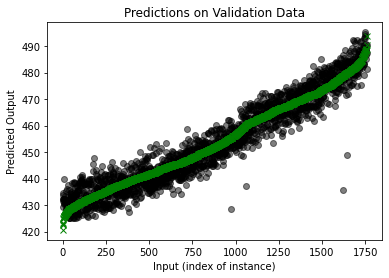

In [52]:
plt.figure()

#the following is just for nice plotting, not required: it sorts the predictions by value so that they fall on
# a line and it's easier to spot the differences
sorting_permutation = sorted(range(len(prediction_validation_reduced[0:m_validation])), key=lambda k: prediction_validation_reduced[0:m_validation][k])
plt.plot(Y_validation[sorting_permutation], 'ko', alpha=0.5)
plt.plot(prediction_validation_reduced[sorting_permutation], 'gx')


plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Validation Data')
plt.show()

# MODEL SELECTION 

**TO DO**: Based on the results of the estimated models (full model and reduced model) **on the validation data** which one would you choose? Explain the choice. Is this choice supported by the predictions of the estimated models **on the test data**? Explain your reasoning.

**ANSWER**

accuracy in full model is higher but we can choose reduced model because it has less Calculations and complexity and its accuracy is not much less than full model

## Ordinary Least-Squares using scikit-learn

A fast way to compute the LS estimate is through sklearn.linear_model

In [53]:
# Remove the ''ones'' column in the features matrix (sklearn inserts it automatically)
X_training = X_training[:,1:]
X_test = X_test[:,1:]


In [54]:
from sklearn import linear_model

lin_reg = linear_model.LinearRegression()  # build the object LinearRegression
lin_reg.fit(X_training, Y_training)  # estimate the LS coefficients
print("Intercept:", lin_reg.intercept_)
print("Least-Squares Coefficients:", lin_reg.coef_)
prediction_training = lin_reg.predict(X_training)  # predict output values on training set
prediction_test = lin_reg.predict(X_test)  # predict output values on test set
print("Measure on training data:", 1-lin_reg.score(X_training, Y_training))

Intercept: 454.0904659090909
Least-Squares Coefficients: [-14.91786875  -2.78189126   0.4424977   -2.45893068]
Measure on training data: 0.06924846201212831
